In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
start_line = 6

data = pd.read_csv('Thesis_Samples_Data/Notched_Layered_4/Notched_Layered_4.csv', skiprows=start_line)
data = data.drop([0])
data

,Crosshead,Load,Time,Extensometer
1,-4.88E-05,-2.018614769,0.108000003,5.40E-05
2,-4.88E-05,-2.0723176,0.128000006,6.56E-05
3,-4.88E-05,-2.153599262,0.148000002,5.15E-05
4,-9.77E-05,-2.028392315,0.167999998,5.39E-05
5,-9.77E-05,-1.95252347,0.187999994,5.50E-05
...,...,...,...,...
41179,-1.647314406,-27.37961578,823.6680298,1.498281141
41180,-1.647314406,-27.28787804,823.6879883,1.498314668
41181,-1.6473633,-27.26520538,823.7080078,1.498378348
41182,-1.647412078,-27.20642662,823.7280273,1.498419908


32.61036682


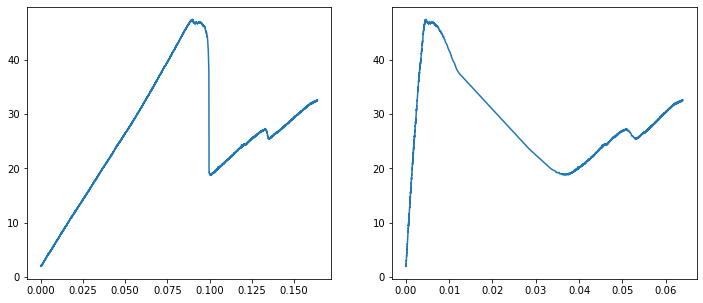

In [20]:
# get relevant columns and preprocess
crosshead = data.loc[:, 'Crosshead '].to_numpy(dtype=np.double)
extenso = data.loc[:, 'Extensometer '].to_numpy(dtype=np.double)
load = data.loc[:, 'Load '].to_numpy(dtype=np.double)

crosshead = abs(crosshead)

min_extenso = np.min(extenso)
if (min_extenso < 0):
    extenso = extenso + abs(min_extenso)
extenso = abs(extenso)

load = abs(load)

stop_index = 4100 - start_line
crosshead = crosshead[0:stop_index]
extenso = extenso[0:stop_index]
load = load[0:stop_index]

print(load[-1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(crosshead, load)

plt.subplot(1, 2, 2)
plt.plot(extenso, load)

### Define Sample Parameters

In [6]:
S = 90      # span, mm
B = 40.43   # width, mm
B_N = B      # side-groove width, mm
W = 23.1   # thickness, mm
a0 = 0.75   # initial crack length, mm
E = 22500    # young's modulous, MPa


## K<sub>ic</sub> Calculation

![title](img/K_ic.png)

Where K<sub>(i)</sub> = K<sub>ic</sub>, P<sub>i</sub> = P<sub>max</sub> (the first, highest peak), and 
![title](img/f_a_W.png)

with a<sub>i</sub> = a<sub>0</sub>

[From E1820]

In [7]:
a_W = a0/W
f_aW = 3*np.sqrt(a_W) * (1.99 - a_W*(1-a_W)*(2.15-3.93*a_W+2.7*a_W**2)) / (2*(1+2*a_W)*np.power(1-a_W, 1.5))

P_max = np.max(load)
pl_index = np.argmax(load)

K_ic = (P_max*S/(np.sqrt(B*B_N)*np.power(W, 1.5))) * f_aW
K_ic

0.4886003050983669

## J<sub>el</sub> Calculation

![title](img/J_el.png)

[from Bouville et al]

E is the young's modulous, so it must first be calulated from the (roughly) linear region before the first peak:

![title](img/modulous.png)

![title](img/wikipedia_terms.png)

[from Wikipedia]

In [8]:
# first find slope of linear load-displacement region
num_reg_points = int(pl_index / 5)
crosshead_reg = crosshead[pl_index-num_reg_points:pl_index]
load_reg = load[pl_index-num_reg_points:pl_index]
A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]

# then calculate E
E_reg = (S**3 * m) / (4*B*W**3)
print(E_reg)

# finally J_el
J_el = K_ic**2/E_reg
J_el

201.05260092486887


0.0011874019885543688

549.7710156379676


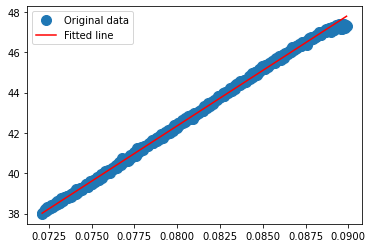

In [9]:
print(m)

_ = plt.plot(crosshead_reg, load_reg, 'o', label='Original data', markersize=10)
_ = plt.plot(crosshead_reg, m*crosshead_reg + c, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

## J<sub>pl</sub> Calculation (using crosshead)

![title](img/J_pl_Bouville.png)

Where A<sub>pl</sub> is the cumulative area under the load-crosshead curve post-peak (after initial max load point) and is calculated using a trapezoidal sum. b = W - a<sub>0</sub>.

[from Bouville et al]

In [10]:
crosshead_pl = crosshead[pl_index:]
extenso_pl = extenso[pl_index:]
load_pl = load[pl_index:]

n_pl = load_pl.shape[0]
A_pl = np.zeros(n_pl)

A_pl[0] = 0.5*(load[pl_index]+load[pl_index-1]) * (crosshead[pl_index]-crosshead[pl_index-1])
for i in range(1, n_pl):
    A_pl[i] = A_pl[i-1] + 0.5*(load_pl[i]+load_pl[i-1]) * (crosshead[i]-crosshead[i-1])
    
J_pl = 1.9*A_pl/(B*(W-a0))

## Crack Length Determination (using crosshead)

To plot an R-curve, K<sub>jc</sub> must be plotted against the crack length a<sub>i</sub>:

![title](img/crack_length_Bouville.png)

with

![title](img/C_Bouville.png)

where u = crosshead displacement and f = load

[from Bouville et al]

In [11]:
C = np.divide(crosshead_pl, load_pl)

a = np.zeros(n_pl)

a[0] = a0
for i in range(1, n_pl):
    a[i] = a[i-1] + 0.5*(W-a[i-1])*((C[i]-C[i-1])/C[i])
    

## Crack Length Determination (using CMOD)

An alternative method, using equations from ASTM E399

![title](img/a_E399.png)

with

![title](img/E_prime.png)

In [39]:
B_e = B-((B-B_N)**2)/B

U = 1/(1+np.sqrt((E_reg*B_e*extenso_pl*1e1/load_pl)) * 4*W/S)

# a = (a/W)*W

a_E399 = W*(1 - 3.950*U + 2.982*np.power(U, 2) - 3.214*np.power(U, 3) + 5.516*np.power(U, 4) - 113.031*np.power(U, 5))

offset = abs(a_E399[0] - a0)
print(offset)
if (a_E399[0] < a0): a_E399 = a_E399 + offset
else: a_E399 = a_E399 - offset

# compare
print(a)
print(a_E399)


0.08939384772683434
[0.75       0.78528848 0.80061114 ... 8.93401641 8.94101456 8.91048472]
[ 0.75        0.80376755  0.88536291 ... 16.98602553 16.98866176
 16.97664456]


## K<sub>jc</sub> Calculation

![title](img/K_jc_Bouville.png)

This is an elemnt-wise calculation for plotting during the plastic region. An overall K<sub>jc</sub> can be found by taking the last/maximum value from this array.

[from Bouville et al]

In [40]:
K_jc = np.sqrt((J_el+J_pl)*E_reg)
K_jc_overall = np.max(K_jc)
K_jc_overall

1.064351591498717

## Plotting

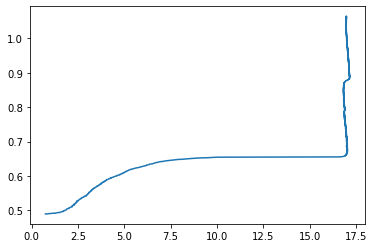

In [44]:
plt.plot(a_E399, K_jc)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

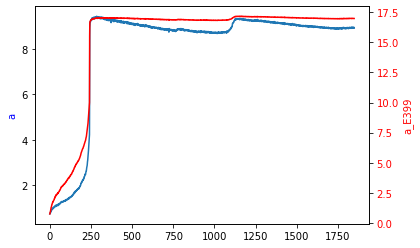

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(a)
ax1.set_ylabel('a', color='b')

ax2 = ax1.twinx()
ax2.plot(a_E399, 'r-')
ax2.set_ylabel('a_E399', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

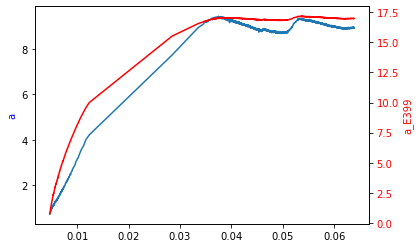

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(extenso_pl, a)
ax1.set_ylabel('a', color='b')

ax2 = ax1.twinx()
ax2.plot(extenso_pl, a_E399, 'r-')
ax2.set_ylabel('a_E399', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
plt.plot